In [1]:
import torch
from utils import load_vocab
from rnn import RNN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
vlist, vdict = load_vocab()

In [3]:
model = RNN(len(vlist), 8, 64)
model.load_state_dict(torch.load('checkpoints/checkpoint999.pt', map_location = torch.device('cpu')))
sum(x.numel() for x in model.parameters() if x.requires_grad)

22010

In [4]:
lst = TSNE(n_components=2).fit_transform(model.embed.weight.data)

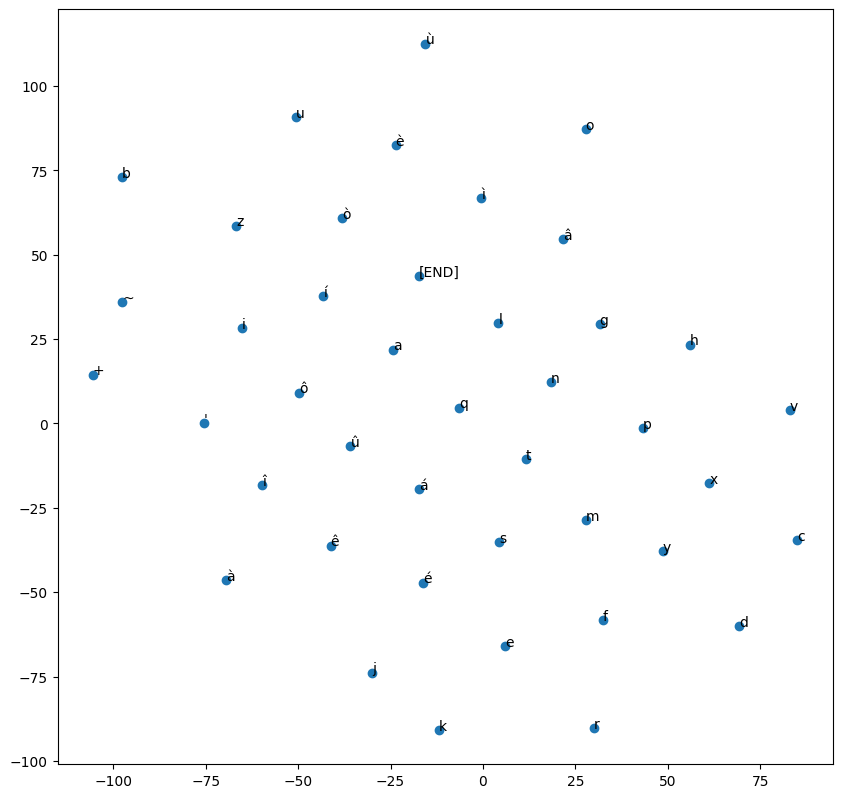

In [5]:
plt.figure(figsize=(10,10), dpi=100)
plt.scatter(lst[:,0], lst[:,1])
for i, (x, y) in enumerate(lst):
    plt.annotate(vlist[i], (x, y))
plt.show()

In [6]:
from torch.nn.utils.rnn import pad_sequence as pad

In [7]:
class BeamSearch:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        
    def calc_dist(self, beam):
        src = [torch.tensor(sent) for prob, sent in beam]
        with torch.no_grad():
            y = self.model({'src':pad(src), 'len':torch.tensor([len(x) for x in src])})
        y = y.permute(1, 0, 2)
        y = y[:, -1]
        y = y + y.new(y.size()).normal_(0, 0.1)
        y = torch.log_softmax(y, dim=-1)
        return y
    
    def cand(self, prob, sent, dist):
        values, indices = dist.topk(self.width)
        return [(prob + v.item(), sent + [i.item()]) for v, i in zip(values, indices)]
    
    def calc_cands(self, beam, dists):
        cands = [
            tup
            for (prob, sent), dist in zip(beam, dists)
            for tup in self.cand(prob, sent, dist)
        ]
        cands.sort(reverse=True)
        return cands[:self.width]
    
    def calc_beam(self, cands):
        beam = []
        for prob, sent in cands:
            if sent[-1] == 0:
                self.width -= 1
                self.output.append((prob, sent))
            else:
                beam.append((prob, sent))
        return beam
    
    def calc_output(self, init):
        beam = [(0, [0] + init)]
        for i in range(self.max_len):
            if self.width == 0:
                break
            dists = self.calc_dist(beam)
            cands = self.calc_cands(beam, dists)
            beam = self.calc_beam(cands)
            
    def search(self, width, init=[], max_len=10):
        self.width = width
        self.max_len = max_len
        self.output = []
        self.calc_output(init)
        return self.output
    
bs = BeamSearch(model)
lst = bs.search(len(vlist))
for prob, sent in lst:
    print(prob, '\t', ''.join([vlist[x] for x in sent[1:-1]]))

-6.14992618560791 	 
-6.913928389549255 	 sok
-6.915403842926025 	 doq
-7.025359392166138 	 kos
-7.282059967517853 	 taq
-8.158779792487621 	 sokal
-8.276251636445522 	 tazis
-8.299288719892502 	 litik
-8.372992098331451 	 solak
-8.441172989085317 	 fetik
-8.500590842217207 	 lisik
-8.511509418487549 	 linék
-8.565562531352043 	 folos
-8.592373453080654 	 fetak
-8.671214431524277 	 tacik
-8.706967055797577 	 kolot
-8.732186257839203 	 celèk
-8.885305106639862 	 folot
-9.082879543304443 	 tedec
-9.108611702919006 	 cafek
-9.144671022891998 	 litav
-9.230189502239227 	 litéz
-8.489750178065151 	 talcat
-8.924502274952829 	 talcas
-9.05694855749607 	 taltic
-9.130078941583633 	 soktel
-9.170854703523219 	 talhif
-9.206128656398505 	 talcaf
-9.299703061580658 	 soktal
-9.330995206721127 	 talcak
-9.417495056986809 	 soktil
-9.473768087103963 	 talcik
-9.511744737625122 	 soktec
-9.561389118432999 	 talhir
-9.60248214006424 	 takvaf
-9.833456158638 	 qiljet
-9.970072507858276 	 desket
-10.3